# Test Model

In [89]:
import numpy as np

from active import split_on_ids
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from pymks import (
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
)

from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [90]:
def make_gp_model_matern():
    kernel = Matern(length_scale=1.0)
    #kernel = 0.5 * RBF(length_scale=1) + WhiteKernel(noise_level=1)
    regressor = GaussianProcessRegressor(kernel=kernel)
    return regressor

def make_linear_model():
    return Pipeline(steps=(
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', LinearRegression()),
    ))


In [91]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

In [92]:
def train_test_split_(x_data, y_data, prop, random_state=None):
    ids = np.random.choice(len(x_data), int(prop * len(x_data)), replace=False)
    x_0, x_1 = split_on_ids(x_data, ids)
    y_0, y_1 = split_on_ids(y_data, ids)
    return x_0, x_1, y_0, y_1

In [93]:
def split(x_data, y_data, train_sizes=(0.9, 0.09), random_state=None):
    x_pool, x_, y_pool, y_ = train_test_split_(
        x_data,
        y_data,
        train_sizes[0],
        random_state=random_state
    )
    x_test, x_calibrate, y_test, y_calibrate = train_test_split_(
        x_,
        y_,
        train_sizes[1] / (1 - train_sizes[0]),
        random_state=random_state
    ) 
    return x_pool, x_test, x_calibrate, y_pool, y_test, y_calibrate

In [94]:
data = np.load('data_pca-500-51-51.npz')

In [95]:
x_data_pca = data['x_data_pca'][:]
y_data = data['y_data']

In [96]:
x_pool, x_test, x_train, y_pool, y_test, y_train = split(x_data_pca, y_data, (0.6, 0.2))

In [97]:
x_train.shape

(100, 15)

In [98]:
x_test.shape

(100, 15)

In [99]:
#model = make_linear_model()
model = make_gp_model_matern()

In [100]:
model.fit(x_train, y_train)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5))

In [101]:
y_train_predict = model.predict(x_train)

In [102]:
y_test_predict = model.predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

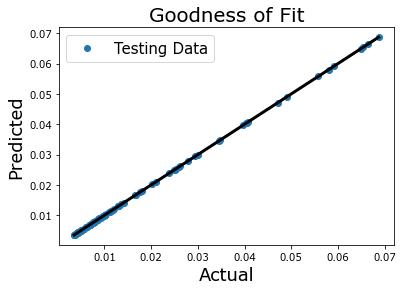

In [103]:
plot_parity(y_train, y_train_predict)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

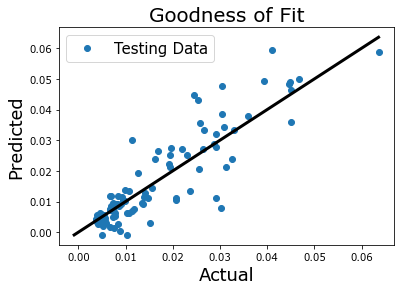

In [104]:
plot_parity(y_test, y_test_predict)

In [105]:
print(r2_score(y_test, y_test_predict))
#print(y_test.shape)
#print(y_test)
print(model.score(x_test, y_test))
#sklearn.metrics.r2_score()

0.7114583673666611
0.7114583673666611


In [106]:
scores = []
for _ in range(40):
    x_pool, x_test, x_train, y_pool, y_test, y_train = split(x_data_pca, y_data, (0.0, 0.2))
    model = make_gp_model_matern()
    model.fit(x_train, y_train)
    print(x_train.shape)
    scores += [model.score(x_test, y_test)]
    
print(scores)

(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
(400, 15)
[0.9384919278871556, 0.862967609408448, 0.9265338006158511, 0.8912152686145357, 0.8488634655346181, 0.9108508334297246, 0.917190615846607, 0.8883264055009283, 0.8224555245680822, 0.9042461386057151, 0.9004964140675795, 0.9073499422179501, 0.9268875703635401, 0.8742310278192272, 0.9146066398667401, 0.870688220654339, 0.8675352773606231, 0.9153582008051233, 0.900826453709577, 0.9017756821535569, 0.9095046414301962, 0.8353759453821735, 0.9008612843025254, 0.8873912723737025, 0.9252064010337369, 0.9231489680478537, 0.9389238488494582, 0.854154930492507, 0.9042317843466091, 0.9004934961195882, 0.91

In [107]:
np.mean(scores)

0.8939050708891709

In [108]:
np.std(scores)

0.03058095196337181